# Gas Sensor Array Drift Dataset

Dado que a partir del instante de predicción no tenemos valores de regresoras, necesitamos modelos autoregresivos univariantes o basados en la serie objetivo:

· ARIMA: Modelos clásicos de series temporales.

· ML con lags: Random Forest usando solo valores pasados como features.

### Librerías necesarias

In [1]:
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "C:\Users\pabli\anaconda3\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\pabli\anaconda3\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\pabli\anaconda3\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "C:\Users\pabli\anaconda3\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
    app.start()
  File "C:\Users\pabli\anaconda3\lib\site-pack

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "C:\Users\pabli\anaconda3\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\pabli\anaconda3\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\pabli\anaconda3\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "C:\Users\pabli\anaconda3\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
    app.start()
  File "C:\Users\pabli\anaconda3\lib\site-pack

AttributeError: _ARRAY_API not found

### Importamos datos

In [2]:
path = "data_gasdrift/"
all_files = glob.glob(path + "batch*.DAT")

dfs = []

for file in all_files:
    with open(file, 'r') as f:
        rows = []
        for line in f:
            line = line.strip()
            if not line:
                continue
            parts = line.split()[1:]  # ignorar el primer índice
            values = [float(p.split(':')[1]) for p in parts]  # extraer solo el valor
            rows.append(values)
    df = pd.DataFrame(rows)
    dfs.append(df)

# Concatenar todos los archivos
data = pd.concat(dfs, ignore_index=True)

# Seleccionamos el sensor 1
y = data.iloc[:,0].values

## Modelos

### ARIMA (univariante)

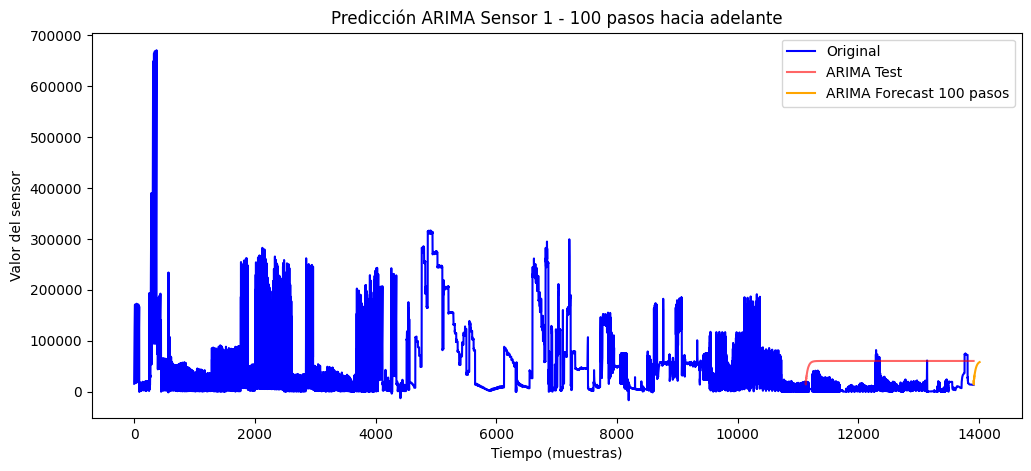

In [10]:
# Dividimos train/test
train_size = int(len(y)*0.8)
train, test = y[:train_size], y[train_size:]

# Ajustamos ARIMA (p,d,q) = (5,0,0) como ejemplo
arima_model = ARIMA(train, order=(5,0,0))
arima_fit = arima_model.fit()

# Predicción multi-step
arima_pred = arima_fit.forecast(steps=len(test))

# Predicción de 100 pasos hacia adelante desde el final del train
arima_forecast_100 = arima_fit.forecast(steps=100)

# Gráfica comparativa
plt.figure(figsize=(12,5))
plt.plot(range(len(y)), y, label='Original', color='blue')
plt.plot(range(train_size, len(y)), arima_pred, label='ARIMA Test', color='red', alpha=0.6)
plt.plot(range(len(y), len(y)+100), arima_forecast_100, label='ARIMA Forecast 100 pasos', color='orange')
plt.title("Predicción ARIMA Sensor 1 - 100 pasos hacia adelante")
plt.xlabel("Tiempo (muestras)")
plt.ylabel("Valor del sensor")
plt.legend()
plt.show()

In [13]:
# Tomamos los primeros 100 puntos del test como referencia
true_future = test[:100]

# KPIs para ARIMA
rmse_arima = np.sqrt(mean_squared_error(true_future, arima_forecast_100))
mae_arima = mean_absolute_error(true_future, arima_forecast_100)

print(f"ARIMA (100 pasos) - RMSE: {rmse_arima:.2f}, MAE: {mae_arima:.2f}")

ARIMA (100 pasos) - RMSE: 42227.84, MAE: 39988.81


### Random Forest con Lags

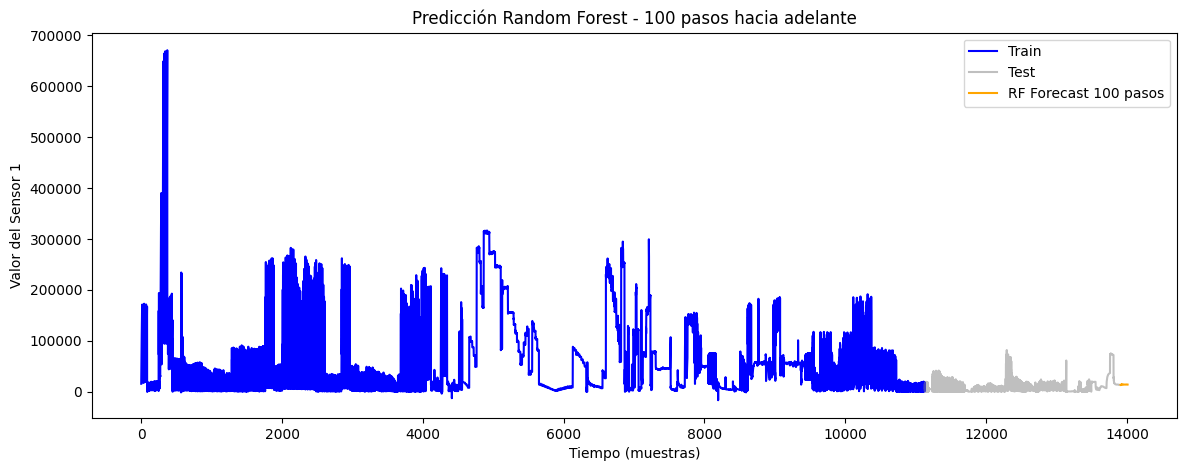

In [15]:
# Predicción recursiva de 100 pasos hacia adelante
SEQ_LENGTH = 20
n_steps = min(100, len(test))  # asegurar que no exceda longitud del test

# Tomamos los últimos SEQ_LENGTH valores reales para iniciar la predicción
history = list(y[-SEQ_LENGTH:])
forecast_rf_100 = []

for _ in range(n_steps):
    X_input = np.array(history[-SEQ_LENGTH:]).reshape(1, -1)  # input con últimos lags
    yhat = rf_model.predict(X_input)[0]
    forecast_rf_100.append(yhat)
    history.append(yhat)  # agregamos la predicción como nuevo lag

# Gráfico comparativo
plt.figure(figsize=(14,5))
plt.plot(range(len(train)), train, label='Train', color='blue')
plt.plot(range(len(train), len(train)+len(test)), test, label='Test', color='grey', alpha=0.5)
plt.plot(range(len(y), len(y)+n_steps), forecast_rf_100, label='RF Forecast 100 pasos', color='orange')
plt.title("Predicción Random Forest - 100 pasos hacia adelante")
plt.xlabel("Tiempo (muestras)")
plt.ylabel("Valor del Sensor 1")
plt.legend()
plt.show()


In [16]:
# KPIs
true_future = test[:n_steps]
rmse_rf = np.sqrt(mean_squared_error(true_future, forecast_rf_100))
mae_rf = mean_absolute_error(true_future, forecast_rf_100)
print(f"Random Forest (100 pasos) - RMSE: {rmse_rf:.2f}, MAE: {mae_rf:.2f}")

Random Forest (100 pasos) - RMSE: 9242.28, MAE: 8431.42


### Evalucación de los modelos

ARIMA - RMSE: 42227.84, MAE: 39988.81
Random Forest - RMSE: 9242.28, MAE: 8431.42


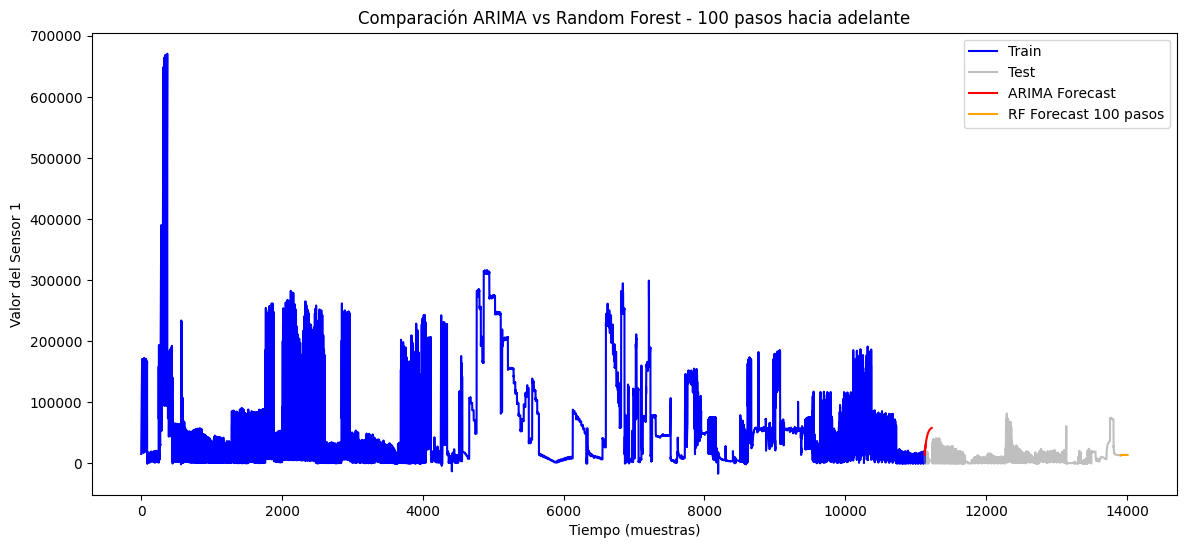

In [18]:
# Función de evaluación
def evaluate(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    print(f"{model_name} - RMSE: {rmse:.2f}, MAE: {mae:.2f}")

# Ajustamos longitud de comparación
n_steps = min(100, len(test))
true_future = test[:n_steps]

# Evaluación de KPIs
evaluate(true_future, arima_forecast_100, "ARIMA")
evaluate(true_future, forecast_rf_100, "Random Forest")

# Gráfico comparativo
plt.figure(figsize=(14,6))
plt.plot(range(len(train)), train, label='Train', color='blue')
plt.plot(range(len(train), len(train)+len(test)), test, label='Test', color='grey', alpha=0.5)
plt.plot(range(len(train), len(train)+n_steps), arima_forecast_100, label='ARIMA Forecast', color='red')
plt.plot(range(len(y), len(y)+n_steps), forecast_rf_100, label='RF Forecast 100 pasos', color='orange')
plt.title("Comparación ARIMA vs Random Forest - 100 pasos hacia adelante")
plt.xlabel("Tiempo (muestras)")
plt.ylabel("Valor del Sensor 1")
plt.legend()
plt.show()

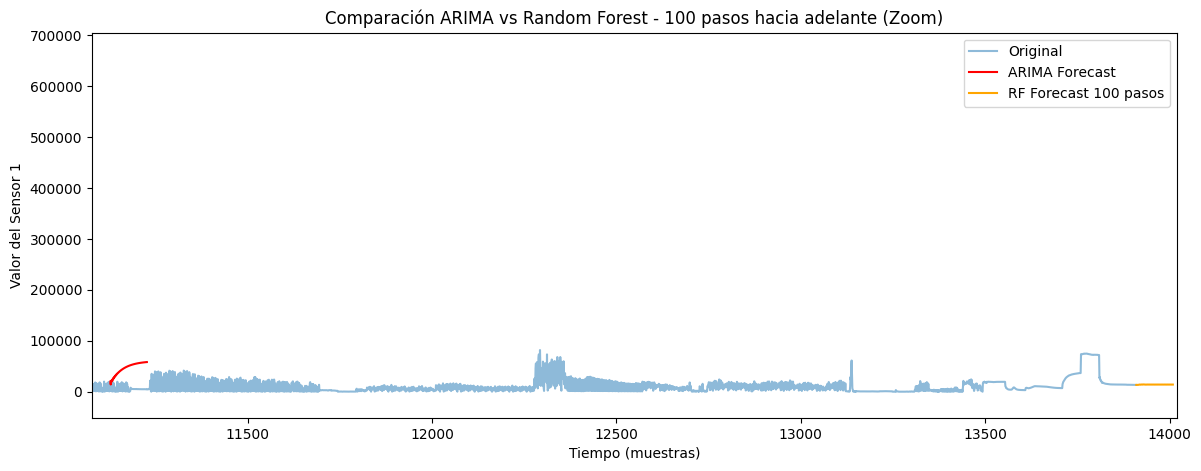

In [19]:
plt.figure(figsize=(14,5))
plt.plot(range(len(y)), y, label='Original', alpha=0.5)
plt.plot(range(len(train), len(train)+n_steps), arima_forecast_100, label='ARIMA Forecast', color='red')
plt.plot(range(len(y), len(y)+n_steps), forecast_rf_100, label='RF Forecast 100 pasos', color='orange')
plt.xlim(len(train)-50, len(y)+n_steps+10)  # zoom en la zona final
plt.title("Comparación ARIMA vs Random Forest - 100 pasos hacia adelante (Zoom)")
plt.xlabel("Tiempo (muestras)")
plt.ylabel("Valor del Sensor 1")
plt.legend()
plt.show()

Random Forest predice el Sensor 1 con mucha mayor precisión que ARIMA, mostrando RMSE=9242.28 y MAE=8431.42 frente a los 42227.84 y 39988.81 de ARIMA, es decir unas métricas de error mucho más bajas. ARIMA suaviza la serie y no captura bien los picos y fluctuaciones del sensor. Por su parte, Random Forest maneja el ruido y los eventos extremos, siendo claramente más adecuado para este dataset.